## Architecture
The region proposal network (RPN) starts with the input image being fed into the backbone convolutional neural network. The input image is first resized such that it’s shortest side is 600px with the longer side not exceeding 1000px.
The output features of the backbone network (indicated by H x W) are usually much smaller than the input image depending on the stride of the backbone network. For both the possible backbone networks used in the paper (VGG, ZF-Net) the network stride is 16. This means that two consecutive pixels in the backbone output features correspond to two points 16 pixels apart in the input image.
For every point in the output feature map, the network has to learn whether an object is present in the input image at its corresponding location and estimate its size. This is done by placing a set of “Anchors” on the input image for each location on the output feature map from the backbone network. These anchors indicate possible objects in various sizes and aspect ratios at this location. The figure below shows 9 possible anchors in 3 different aspect ratios and 3 different sizes placed on the input image for a point A on the output feature map. For the PASCAL challenge, the anchors used have 3 scales of box area 128², 256², 512² and 3 aspect ratios of 1:1, 1:2 and 2:1.

As the network moves through each pixel in the output feature map, it has to check whether these k corresponding anchors spanning the input image actually contain objects, and refine these anchors’ coordinates to give bounding boxes as “Object proposals” or regions of interest.
First, a 3 x 3 convolution with 512 units is applied to the backbone feature map as shown in Figure 1, to give a 512-d feature map for every location. This is followed by two sibling layers: a 1 x 1 convolution layer with 18 units for object classification, and a 1 x 1 convolution with 36 units for bounding box regression.
The 18 units in the classification branch give an output of size (H, W, 18). This output is used to give probabilities of whether or not each point in the backbone feature map (size: H x W) contains an object within all 9 of the anchors at that point.
The 36 units in the regression branch give an output of size (H, W, 36). This output is used to give the 4 regression coefficients of each of the 9 anchors for every point in the backbone feature map (size: H x W). These regression coefficients are used to improve the coordinates of the anchors that contain objects.


# Here are all the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [32]:
!unzip file.zip

Archive:  file.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/105_jpg.rf.3cde2fcd15a9bdf6a2d2d32aff48f33d.jpg  
 extracting: test/10_jpg.rf.d362a00f9a6b4ac31668dc8aae9c71de.jpg  
 extracting: test/117_jpg.rf.119dccd2483b04d8d3a8c33a1393d362.jpg  
 extracting: test/118_jpg.rf.acee2a86eba65adc57f3b15d5acab93c.jpg  
 extracting: test/11_jpg.rf.8e1c22ba2779121f3ba0a8ae03a20407.jpg  
 extracting: test/124_jpg.rf.100aeaede7a9c017d7f74f73cfcf34d7.jpg  
 extracting: test/124_jpg.rf.dab4a5f6292af8332da8f9bad9751ba6.jpg  
 extracting: test/12_jpg.rf.3e4b2f52016c100e9f869397933ef2d3.jpg  
 extracting: test/131_jpg.rf.1a70e4c9e91ea953aa55988ab20fa95a.jpg  
 extracting: test/135_jpg.rf.a8cbe93a3de035a4927b20c42604ae4c.jpg  
 extracting: test/145_jpg.rf.5a3d6fbf3dcb9d88626ba82182f29254.jpg  
 extracting: test/164_jpg.rf.9a5230f67ddc2426d52597a70c6984f9.jpg  
 extracting: test/165_jpg.rf.e831420b761a317ab9fb725e12781bd8.jpg  
 extr

PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [4]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [5]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [33]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [64]:
class FractureDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [65]:
dataset_path = "/content/"

In [67]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'bone-fracture', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'angle', 'supercategory': 'bone-fracture'},
 2: {'id': 2, 'name': 'fracture', 'supercategory': 'bone-fracture'},
 3: {'id': 3, 'name': 'line', 'supercategory': 'bone-fracture'},
 4: {'id': 4, 'name': 'messed_up_angle', 'supercategory': 'bone-fracture'}}

This code just gets a list of classes

In [68]:
classes = [i[1]['name'] for i in categories.items()]
classes

['bone-fracture', 'angle', 'fracture', 'line', 'messed_up_angle']

In [69]:
train_dataset = FractureDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

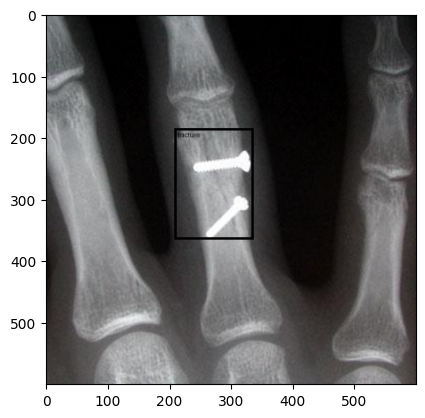

In [70]:
# Lets view a sample
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [71]:
len(train_dataset)

311

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [72]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [73]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [74]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

The following blocks ensures that the model can take in the data and that it will not crash during training

In [75]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [76]:
device = torch.device("cuda") # use GPU to train

In [77]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [78]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [48]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [79]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [80]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 39/39 [00:12<00:00,  3.04it/s]


Epoch 0, lr: 0.001000, loss: 0.311922, loss_classifier: 0.177168, loss_box: 0.023605, loss_rpn_box: 0.008367, loss_object: 0.102781


100%|██████████| 39/39 [00:13<00:00,  2.79it/s]


Epoch 1, lr: 0.001000, loss: 0.144118, loss_classifier: 0.060796, loss_box: 0.027007, loss_rpn_box: 0.007586, loss_object: 0.048730


100%|██████████| 39/39 [00:13<00:00,  2.79it/s]


Epoch 2, lr: 0.001000, loss: 0.147055, loss_classifier: 0.065204, loss_box: 0.033301, loss_rpn_box: 0.006976, loss_object: 0.041574


100%|██████████| 39/39 [00:14<00:00,  2.77it/s]


Epoch 3, lr: 0.001000, loss: 0.158702, loss_classifier: 0.073160, loss_box: 0.040532, loss_rpn_box: 0.007088, loss_object: 0.037922


100%|██████████| 39/39 [00:14<00:00,  2.66it/s]


Epoch 4, lr: 0.001000, loss: 0.167801, loss_classifier: 0.079897, loss_box: 0.046927, loss_rpn_box: 0.006720, loss_object: 0.034258


100%|██████████| 39/39 [00:14<00:00,  2.75it/s]


Epoch 5, lr: 0.001000, loss: 0.170712, loss_classifier: 0.081660, loss_box: 0.050220, loss_rpn_box: 0.006634, loss_object: 0.032197


100%|██████████| 39/39 [00:13<00:00,  2.80it/s]


Epoch 6, lr: 0.001000, loss: 0.177908, loss_classifier: 0.086170, loss_box: 0.055723, loss_rpn_box: 0.006455, loss_object: 0.029560


100%|██████████| 39/39 [00:13<00:00,  2.81it/s]


Epoch 7, lr: 0.001000, loss: 0.189375, loss_classifier: 0.092746, loss_box: 0.061467, loss_rpn_box: 0.006500, loss_object: 0.028662


100%|██████████| 39/39 [00:13<00:00,  2.82it/s]


Epoch 8, lr: 0.001000, loss: 0.187760, loss_classifier: 0.092206, loss_box: 0.062121, loss_rpn_box: 0.006281, loss_object: 0.027153


100%|██████████| 39/39 [00:13<00:00,  2.84it/s]

Epoch 9, lr: 0.001000, loss: 0.196018, loss_classifier: 0.097244, loss_box: 0.066763, loss_rpn_box: 0.006124, loss_object: 0.025888


In [51]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [81]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [82]:
test_dataset = FractureDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [97]:
# it did learn

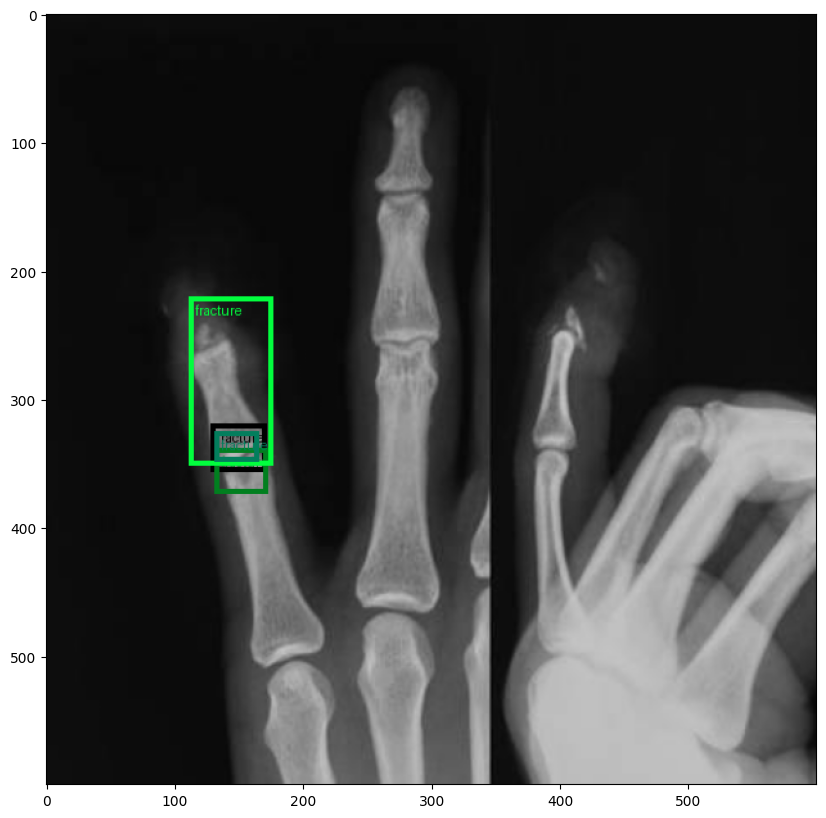

In [109]:
img, _ = test_dataset[9]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.06],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.06].tolist()], width=4
).permute(1, 2, 0))